In [13]:
import lightgbm

print(lightgbm.__version__)

4.3.0


### LightGBM 적용 – 위스콘신 Breast Cancer Prediction

LBGM은 XGBoost에 비해서 소요시간 및 메모리 사용량이 상대적으로 적음.
그러면서 예측 성능은 별다른 차이가 없음
-> 한가지 단점으로 알려진 것은 적은 데이터 세트에 사용될 경우 과적합이 발생하기 쉽다는 것 (일반적으로 10000건 정도)

LGBM은 Leaf-wise 트리 분할 방법을 사용함
대부분의 트리 기반 알고리즘은 트리의 깊이를 줄이기 위해 Level-wise  트리 분할 방식을 사용함 (오버피팅에 보다 강함)
그러나 LGBM은 최대 손실값(Max data loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고, 비대칭적인 규칙트리가 생성됨 -> 예측 오류 손실을 줄일 수 있음

In [14]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05, early_stopping_rounds=50) # 조기 중단은 여기에 추가해야

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. -> 불가능, early_stopping_rounds 파라미터가 없음
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, eval_metric="logloss", eval_set=evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training un

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [16]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


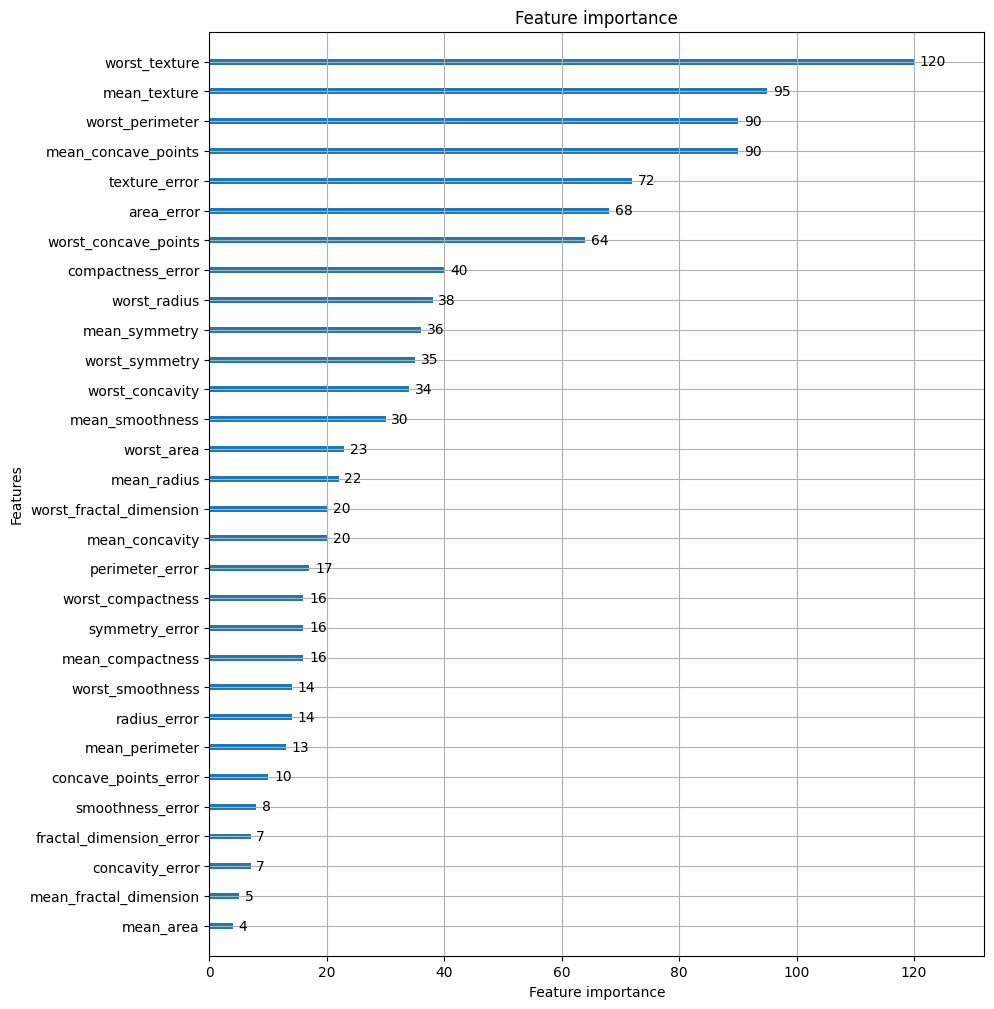

In [17]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

# xgboost와 동일하게 feature importance를 시각화하는 기능 제공

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')